In [21]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [22]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules 
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.colors as pc

# pandas module 
import pandas as pd

# pyspark SQL functions 
from pyspark.sql.functions import col, when, count, udf

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [23]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

In [24]:
file_path = "/home/zbyszek/Downloads/kaggle/input/WA_Fn-UseC_-Telco-Customer-Churn.csv"
data = spark.read.format('csv') \
    .option("inferSchema", True) \
    .option("header", True) \
    .load(file_path)
data.show(4)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [25]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [26]:
from pyspark.sql.functions import col

data = data.withColumn("TotalCharges", col("TotalCharges").cast("double"))

In [27]:
data.count()

7043

In [28]:
len(data.columns)

21

In [29]:
data.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'int'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

In [30]:
numerical_col = [name for name,typ in data.dtypes if typ=="double" or typ=="int"]
categorical_col = [name for name,typ in data.dtypes if typ=="string"]
numerical_col

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [31]:
df = data.select(numerical_col).toPandas()
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15
3,0,45,42.30,1840.75
4,0,2,70.70,151.65


/tmp/ipykernel_40636/4051979451.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=ax, bins = 20)


array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'MonthlyCharges'}>,
        <Axes: title={'center': 'TotalCharges'}>]], dtype=object)

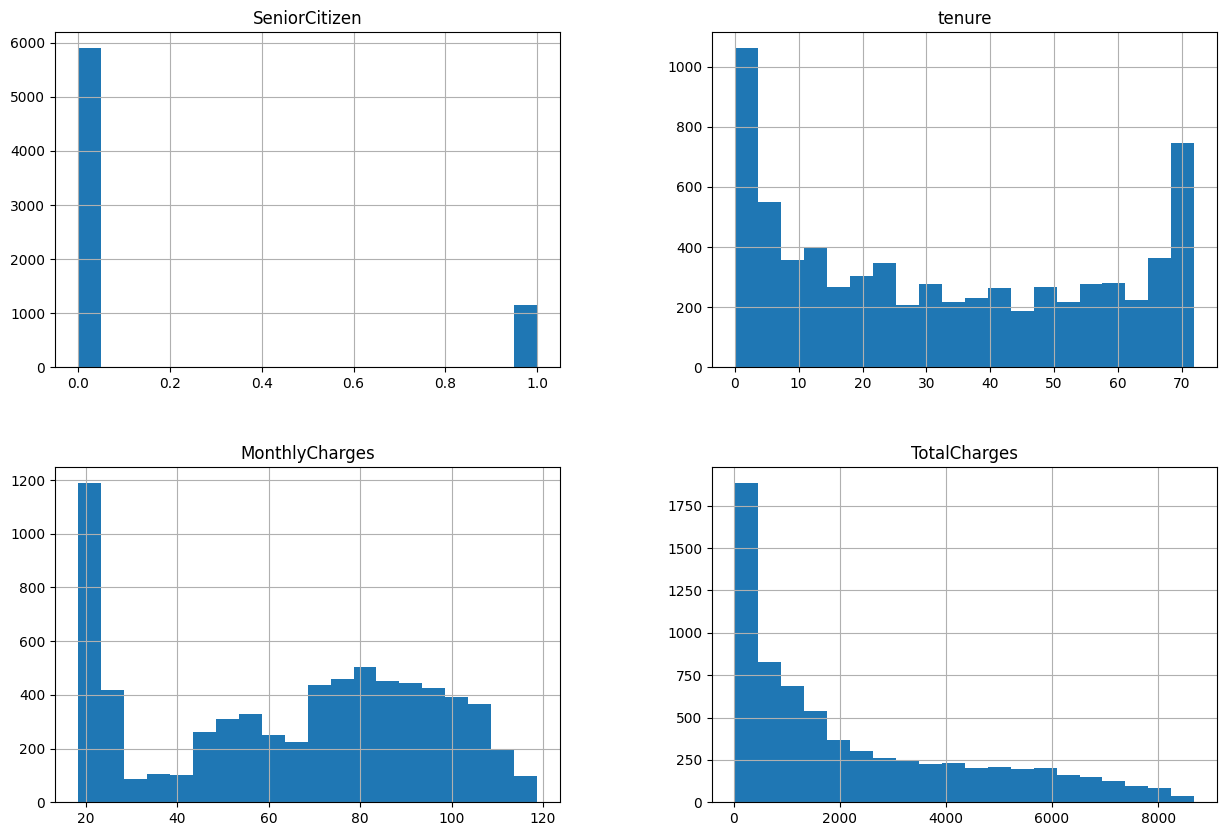

In [32]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca() 
df.hist(ax=ax, bins = 20)

In [33]:
df.corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.016567,0.220173,0.102411
tenure,0.016567,1.000000,0.247900,0.825880
MonthlyCharges,0.220173,0.247900,1.000000,0.651065
TotalCharges,0.102411,0.825880,0.651065,1.000000


In [34]:
data.groupby("contract").count().show()

+--------------+-----+
|      contract|count|
+--------------+-----+
|Month-to-month| 3875|
|      One year| 1473|
|      Two year| 1695|
+--------------+-----+



In [35]:
for coll in categorical_col:
    data.groupby(coll).count().show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682|
|         Yes| 6361|
+------------+-----+

+----------------+-----+
|   MultipleLines|count|
+----------------+-----+
|No phone ser

In [36]:
for coll in data.columns:
    data.select(count(when(col(coll).isNull(), coll)).alias(coll)).show()

+----------+
|customerID|
+----------+
|         0|
+----------+

+------+
|gender|
+------+
|     0|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            0|
+-------------+

+-------+
|Partner|
+-------+
|      0|
+-------+

+----------+
|Dependents|
+----------+
|         0|
+----------+

+------+
|tenure|
+------+
|     0|
+------+

+------------+
|PhoneService|
+------------+
|           0|
+------------+

+-------------+
|MultipleLines|
+-------------+
|            0|
+-------------+

+---------------+
|InternetService|
+---------------+
|              0|
+---------------+

+--------------+
|OnlineSecurity|
+--------------+
|             0|
+--------------+

+------------+
|OnlineBackup|
+------------+
|           0|
+------------+

+----------------+
|DeviceProtection|
+----------------+
|               0|
+----------------+

+-----------+
|TechSupport|
+-----------+
|          0|
+-----------+

+-----------+
|StreamingTV|
+-----------+
|          0|
+----------

In [37]:
col_with_missing_val = ["TotalCharges"]

In [38]:
imputer = Imputer(inputCols=col_with_missing_val, outputCols=col_with_missing_val).setStrategy("mean")

In [39]:
imputer_model = imputer.fit(data)
data = imputer_model.transform(data)

In [40]:
numerical_vector_assembler = VectorAssembler(inputCols= numerical_col, outputCol= "numerical_features_vector")
data = numerical_vector_assembler.transform(data)
data.show(1)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+-------------------------+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|           

In [41]:
scaler = StandardScaler(inputCol="numerical_features_vector",
                        outputCol= "numerical_features_scaled", withStd = True, withMean=True)
data = scaler.fit(data).transform(data)
data.show(1)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+-------------------------+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|numerical_features_scaled|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+-------------------------+-------------------------+
|7590-VHVEG|Female|   

In [42]:
categorical_col_index = [name+"_idx" for name in categorical_col]
categorical_col_index

['customerID_idx',
 'gender_idx',
 'Partner_idx',
 'Dependents_idx',
 'PhoneService_idx',
 'MultipleLines_idx',
 'InternetService_idx',
 'OnlineSecurity_idx',
 'OnlineBackup_idx',
 'DeviceProtection_idx',
 'TechSupport_idx',
 'StreamingTV_idx',
 'StreamingMovies_idx',
 'Contract_idx',
 'PaperlessBilling_idx',
 'PaymentMethod_idx',
 'Churn_idx']

In [43]:
indexer = StringIndexer(inputCols=categorical_col, outputCols=categorical_col_index)
data = indexer.fit(data).transform(data)
data.show(1)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+-------------------------+-------------------------+--------------+----------+-----------+--------------+----------------+-----------------+-------------------+------------------+----------------+--------------------+---------------+---------------+-------------------+------------+--------------------+-----------------+---------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|numerical_features_scaled|customerID_idx|gender_idx|Partner_idx|Dependents_idx|PhoneService_idx|

In [44]:
categorical_col_index.remove("customerID_idx")
categorical_col_index.remove("Churn_idx")

In [45]:
categorical_vector_assembler = VectorAssembler(inputCols=categorical_col_index, outputCol="categorical_features")
data = categorical_vector_assembler.transform(data)
data.show(1)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+-------------------------+-------------------------+--------------+----------+-----------+--------------+----------------+-----------------+-------------------+------------------+----------------+--------------------+---------------+---------------+-------------------+------------+--------------------+-----------------+---------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|numerical_features_scaled|customerID_idx|gender_idx|Partner_idx|Dependents_

In [46]:


final_vector_assembler = VectorAssembler(inputCols=["categorical_features","numerical_features_scaled"], outputCol="final_features")
data = final_vector_assembler.transform(data)

data.select(["final_features","Churn_idx"]).show()



+--------------------+---------+
|      final_features|Churn_idx|
+--------------------+---------+
|(19,[0,1,3,4,5,7,...|      0.0|
|(19,[5,6,8,12,13,...|      0.0|
|(19,[5,6,7,14,15,...|      1.0|
|[0.0,0.0,0.0,1.0,...|      0.0|
|(19,[0,15,16,17,1...|      1.0|
|(19,[0,4,8,10,11,...|      1.0|
|(19,[2,4,7,10,14,...|      0.0|
|(19,[0,3,4,5,6,13...|      0.0|
|(19,[0,1,4,8,9,10...|      1.0|
|(19,[2,5,6,7,12,1...|      0.0|
|(19,[1,2,5,6,14,1...|      0.0|
|[0.0,0.0,0.0,0.0,...|      0.0|
|[0.0,1.0,0.0,0.0,...|      0.0|
|(19,[4,7,8,10,11,...|      1.0|
|(19,[6,8,9,10,11,...|      0.0|
|[1.0,1.0,1.0,0.0,...|      0.0|
|[1.0,0.0,0.0,0.0,...|      0.0|
|[0.0,0.0,1.0,0.0,...|      0.0|
|[1.0,1.0,1.0,0.0,...|      1.0|
|(19,[0,7,8,11,15,...|      0.0|
+--------------------+---------+
only showing top 20 rows



In [47]:
train, test = data.randomSplit([0.7, 0.3], seed = 100)
print(train.count())
print(test.count())

4931
2112


In [48]:
dt = DecisionTreeClassifier(featuresCol="final_features", labelCol="Churn_idx", maxDepth=3)
model = dt.fit(train)

In [49]:
prediction_test = model.transform(test)
prediction_test.select(["Churn_idx", "prediction"]).show()

+---------+----------+
|Churn_idx|prediction|
+---------+----------+
|      1.0|       1.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      1.0|       0.0|
|      0.0|       0.0|
|      1.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      1.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
|      0.0|       0.0|
+---------+----------+
only showing top 20 rows



In [50]:
evaluator = BinaryClassificationEvaluator(labelCol="Churn_idx")
auc_test = evaluator.evaluate(prediction_test, {evaluator.metricName: "areaUnderROC"})
auc_test

0.7617045633750168

In [51]:
prediction_train = model.transform(train)
evaluator = BinaryClassificationEvaluator(labelCol="Churn_idx")
auc_train = evaluator.evaluate(prediction_train, {evaluator.metricName: "areaUnderROC"})
auc_train

0.7712918493814211

In [52]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_features', labelCol = 'Churn_idx', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error 
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_idx")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy 
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_idx")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies) 

In [53]:
maxDepths = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
test_acc, train_acc = evaluate_dt(maxDepths)
print(train_acc)
print(test_acc)

[0.7789865142153861, 0.7712918493814211, 0.6826591069812441, 0.5698050008614369, 0.7097267756814049, 0.8007120163953875, 0.7888573028682286, 0.7956189539598643, 0.8211433720288286, 0.861543087146816, 0.8869290674809027, 0.9051710947878245, 0.9438019298702311, 0.9689805155962002, 0.9801039509144436, 0.9866789573385414, 0.9904768252507075, 0.9909386686251257, 0.991859001848212]
[0.7788716846464305, 0.7617045633750168, 0.6707372773945599, 0.5568304606596539, 0.6941230411597387, 0.7787209933941159, 0.754992377826191, 0.7483023871129775, 0.7435083026207427, 0.7541466377744421, 0.734785732225149, 0.7140236316591807, 0.7244768151579045, 0.7129863151316211, 0.7097137450280647, 0.7071496574402345, 0.7040645752901391, 0.7030885865978237, 0.7027474870189415]


In [54]:
ddf = pd.DataFrame()
ddf["maxDepth"] = maxDepths
ddf["trainAcc"] = train_acc
ddf["testAcc"] = test_acc
ddf.head()

,maxDepth,trainAcc,testAcc
0,2,0.778987,0.778872
1,3,0.771292,0.761705
2,4,0.682659,0.670737
3,5,0.569805,0.556830
4,6,0.709727,0.694123


In [55]:
my_palette = pc.qualitative.Bold
px.line(ddf, x = "maxDepth", y = ["trainAcc", "testAcc"], color_discrete_sequence=my_palette)

In [56]:
dt = DecisionTreeClassifier(featuresCol="final_features", labelCol="Churn_idx", maxDepth=7)
model = dt.fit(train)

In [57]:
feature_importance = model.featureImportances
scores = [score for i, score in enumerate(feature_importance)]

ff = pd.DataFrame(scores, columns=["score"], index = categorical_col_index + numerical_col)
px.bar(ff, y = "score", color_discrete_sequence=my_palette)

In [58]:


df = data.groupby(["Contract", "Churn"]).count().toPandas()

px.bar(df, x = "Contract", y = "count", color = "Churn", color_discrete_sequence=my_palette)

